# Boosting to predict stock 'A' open price

# Import Libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,accuracy_score

import warnings
warnings.filterwarnings("ignore")

# Read Data

In [12]:
symbol = 'A'

# Read data
data = pd.read_csv('train_data.csv')
data = data.dropna(axis=0)
data['id'] = data['symbol'] + '-' + data['day'].astype(str) + '-' + data['time']
data['day num'] = (data['day'] + 1).apply(str)
data = data.loc[data['symbol'] == symbol]
data

,symbol,open,high,low,close,average,time,day,id,day num
2590328,A,135.54,135.79,135.54,135.79,135.67,06:29:50,0,A-0-06:29:50,1
2590329,A,135.79,135.79,135.79,135.79,135.79,06:29:55,0,A-0-06:29:55,1
2590330,A,135.73,135.95,135.68,135.86,135.74,06:30:00,0,A-0-06:30:00,1
2590331,A,135.73,135.98,135.73,135.98,135.91,06:30:05,0,A-0-06:30:05,1
2590332,A,135.89,135.89,135.89,135.89,135.89,06:30:10,0,A-0-06:30:10,1
...,...,...,...,...,...,...,...,...,...,...
3017220,A,146.30,146.32,146.28,146.28,146.29,12:59:35,86,A-86-12:59:35,87
3017221,A,146.28,146.30,146.27,146.29,146.29,12:59:40,86,A-86-12:59:40,87
3017222,A,146.30,146.32,146.30,146.32,146.31,12:59:45,86,A-86-12:59:45,87
3017223,A,146.29,146.30,146.26,146.26,146.28,12:59:50,86,A-86-12:59:50,87


# Time + Date

In [13]:
# Initialize year
year = "2021"

def day_to_date(day_num):
    res = []
    for i in range(len(day_num)):
        res.append(datetime.strptime(year + "-" + day_num[i], "%Y-%j").strftime("%m-%d-%Y"))
    return res

In [14]:
data['date'] = day_to_date(data["day num"].values)
data['date time'] = data.date.astype(str) + ' ' + data.time.astype(str)
data['sec'] = data.time.str[0:2].astype(int)*3600 + data.time.str[3:5].astype(int)*60 + data.time.str[6:8].astype(int)

In [15]:
data['date time'] = pd.to_datetime(data['date time'])

In [16]:
data['pct change'] = data['open'].pct_change() 
data['prev close diff'] = data['open'] - data['close'].shift(1)
data = data.dropna()

In [17]:
data

,symbol,open,high,low,close,average,time,day,id,day num,date,date time,sec,pct change,prev close diff
2590329,A,135.79,135.79,135.79,135.79,135.79,06:29:55,0,A-0-06:29:55,1,01-01-2021,2021-01-01 06:29:55,23395,0.001844,0.00
2590330,A,135.73,135.95,135.68,135.86,135.74,06:30:00,0,A-0-06:30:00,1,01-01-2021,2021-01-01 06:30:00,23400,-0.000442,-0.06
2590331,A,135.73,135.98,135.73,135.98,135.91,06:30:05,0,A-0-06:30:05,1,01-01-2021,2021-01-01 06:30:05,23405,0.000000,-0.13
2590332,A,135.89,135.89,135.89,135.89,135.89,06:30:10,0,A-0-06:30:10,1,01-01-2021,2021-01-01 06:30:10,23410,0.001179,-0.09
2590333,A,135.93,135.93,135.78,135.78,135.87,06:30:15,0,A-0-06:30:15,1,01-01-2021,2021-01-01 06:30:15,23415,0.000294,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3017220,A,146.30,146.32,146.28,146.28,146.29,12:59:35,86,A-86-12:59:35,87,03-28-2021,2021-03-28 12:59:35,46775,0.000000,0.00
3017221,A,146.28,146.30,146.27,146.29,146.29,12:59:40,86,A-86-12:59:40,87,03-28-2021,2021-03-28 12:59:40,46780,-0.000137,0.00
3017222,A,146.30,146.32,146.30,146.32,146.31,12:59:45,86,A-86-12:59:45,87,03-28-2021,2021-03-28 12:59:45,46785,0.000137,0.01
3017223,A,146.29,146.30,146.26,146.26,146.28,12:59:50,86,A-86-12:59:50,87,03-28-2021,2021-03-28 12:59:50,46790,-0.000068,-0.03


# Split data into Train & Test Sets

In [26]:
data.sort_values(['day','time'],ascending=[True,True],inplace=True)
# X = data.drop(['symbol','open','high','low','close','average','time','day','id','date','date time','pct change','prev close diff'], axis=1)
X = data.drop(['symbol','open','close','time','day','id','date','date time'], axis=1)
y = data['open']

data_size = len(data)
train_size = round(data_size*0.85)

# Train
X_train = X.iloc[:train_size, :]
y_train = y.iloc[:train_size]

# # Test
X_test = X.iloc[train_size:,:]
y_test = y.iloc[train_size:]

(X_train)
print(round(len(X_train) / data_size, 2)*100,'% of data set used for training')

# # Train
# X_train = X
# y_train = y

85.0 % of data set used for training


# Boosting Model (Gradient Boosting Regressor)

In [27]:
boost = GradientBoostingRegressor(learning_rate=.05, n_estimators=2000, 
            random_state=1, max_depth=3, validation_fraction=0.1)
boost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=2000,
                          n_iter_no_change=None, presort='auto', random_state=1,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [28]:
predict = boost.predict(X_test)
print('Spread is:', predict.max() - predict.min())
predict

Spread is: 8.603312425153831


array([148.91415628, 148.90932548, 148.90932548, ..., 146.33453068,
       146.26744976, 146.28661834])

In [29]:
results = pd.DataFrame(y_test)
results['prediction'] = predict
results.max(), results.min()

(open          151.12000
 prediction    151.14811
 dtype: float64, open          142.540000
 prediction    142.544797
 dtype: float64)

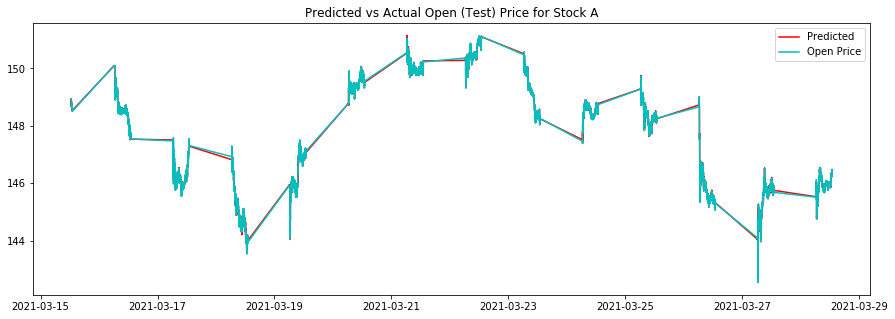

In [30]:
# Plot title
stock = symbol
plot_title = 'Predicted vs Actual Open (Test) Price for Stock ' + stock

# Plot of 'predictions' vs 'open price'
plt.figure(figsize=(15, 5))
plt.plot(data['date time'].iloc[train_size:], predict[:], label='Predicted', color='r')
plt.plot(data['date time'].iloc[train_size:], data['open'].iloc[train_size:], label='Open Price', color='c')
plt.title(plot_title)
plt.legend()

In [ ]:
# # Test And Train Data
# plt.figure(figsize=(15, 5))
# plt.plot(data['date time'].iloc[:train_size], y_train, color='tab:blue', label='Train Set')
# plt.plot(data['date time'].iloc[train_size:], y_test, color='tab:olive', label='Test Set')
# plt.plot(data['date time'].iloc[train_size:], predict[:], label='Predicted', color='m')
# plot_title = 'Data Set for Stock ' + stock
# plt.title(plot_title)
# plt.legend()
# plt.grid()

In [ ]:
# # Plot of Train Data Set
# plt.figure(figsize=(15, 5))
# plt.plot(data['date time'].iloc[:train_size], y_train, color='c')
# plot_title = 'Train Set for Stock ' + stock
# plt.title(plot_title)

In [ ]:
# # Plot of Test Data Set
# plt.figure(figsize=(15, 5))
# plt.plot(data['date time'].iloc[train_size:], y_test.iloc[:], color='c')
# stock = data['symbol'].iloc[0]
# plot_title = 'Test Set for Stock ' + stock
# plt.title(plot_title)

In [ ]:
# # Mean Squared Error
# import math
# mse = mean_squared_error(y_test, predict)
# rmse = math.sqrt(mse)
# mse, rmse

# Forecast 9 days

Generate future times for forecasting

In [ ]:
# Initialize unique time DataFrame
unique_time = pd.DataFrame(data.time.unique(), columns=['time'])
unique_time.sort_values(by=['time'],ascending=[True],inplace=True)

last_day = int(data['day num'].iloc[-1]) # last day in original data set (day 86)
dayspredict = (1, 2, 3, 4, 5, 6, 7, 8, 9) # days to forecast

# Initialize list to store DataFrames
stack = [] 

# Loop through days to forecast and create a DataFrame for each
# Append each DataFrame to list
for i in range(len(dayspredict)):
    # Create dataframe with time column
    temp = unique_time.copy()
    temp.sort_values(by=['time'],ascending=[True],inplace=True)
        
    first_future_day = last_day + dayspredict[i] # next future day to forecast

    # Add the day number in 'day num' column (same value for all time entries)
    temp['day num'] = first_future_day
    
    stack.append(temp)
    del temp # clear temporary dataframe

In [ ]:
zero = stack[0].copy()
one = stack[1].copy()
two = stack[2].copy()
three = stack[3].copy()
four = stack[4].copy()
five = stack[5].copy()
six = stack[6].copy()
seven = stack[7].copy()
eight = stack[8].copy()
future_time = pd.DataFrame()
future_time = future_time.append([zero,one,two,three,four,five,six,seven,eight])

In [ ]:
future_time['sec'] = future_time.time.str[0:2].astype(int)*3600 + future_time.time.str[3:5].astype(int)*60 + future_time.time.str[6:8].astype(int)
future_time['day num'].astype(int)

In [ ]:
predict = boost.predict(future_time.drop(['time'], axis=1))
print('Spread is:', predict.max() - predict.min())
predict

In [ ]:
# Plot of Test Data Set
plt.figure(figsize=(15, 5))
plt.plot(predict)

# plt.plot(future_time['day num'], y_test.iloc[:], color='c')
# stock = data['symbol'].iloc[0]
# plot_title = 'Test Set for Stock ' + stock
# plt.title(plot_title )

In [ ]:
future_time['predicted'] = predict
future_time['symbol'] = symbol
future_time['ID'] = future_time['symbol'] + '-' + future_time['day num'].astype(str) + '-' + future_time['time']

In [ ]:
export = pd.DataFrame()
export['id'] = future_time['ID']
export['open'] = future_time['predicted']
export

In [ ]:
file_name = 'export_stock_' + symbol + '.csv'
export.to_csv(file_name, index=False)

In [ ]:
export['day'] = (export.id.str[2:4].astype(int)).apply(str)

In [ ]:
export['date'] = day_to_date(export['day'].values)
export['time'] = export.id.str[5:]
export['date time'] = export.date.astype(str) + ' ' + export.time.astype(str)
export